In [1]:
# import relevant modules and files

import numpy as np
import pandas as pd
#import mkl
#mkl.set_num_threads(1) # set the number of python threads to be 1 to stop the python parallelisation

df_annotations = {}

for i in range(1, 23):
    df_annotations[i] = pd.read_csv(f"{i}permutationready.tsv", sep="\t")


In [ ]:
# comparing the numba and numpy data for 1000 

In [2]:
# !pip install numba
# turns out numba is already installed

In [3]:
annotations = ['3_prime_UTR_variant','5_prime_UTR_variant','NMD_transcript_variant','coding_sequence_variant','downstream_gene_variant','incomplete_terminal_codon_variant','intergenic_variant','intron_variant','mature_miRNA_variant','missense_variant','non_coding_transcript_exon_variant','non_coding_transcript_variant','splice_acceptor_variant','splice_donor_variant','splice_region_variant','start_lost','stop_gained','stop_lost','stop_retained_variant','synonymous_variant','upstream_gene_variant']


In [4]:
# do for all chromosomes
df_noheader = {}
np_df = {}
location_vec = {}
annotation_matrix = {}
a_matrix = {}

for i in range(1,23):
    df_noheader[i] = df_annotations[i].copy()
    np_df[i] = df_noheader[i].to_numpy()
    location_vec[i] = np_df[i][::,1] # location of significant SNPs
    annotation_matrix[i] = np_df[i][:,2:] # location of annotations
    a_matrix[i] = annotation_matrix[i].transpose()
    

In [5]:
# Below we try the different parallelisations on a computer with 8 CPU corees, each core 32G of ram
# 1) numba parallelisation (with no numpy threading)
# 2) mp pool multi processing parallelisation (with no numpy threading)




In [6]:
import random
import time
from multiprocessing import Process, Manager
import multiprocessing as mp
import numba

In [7]:
@numba.njit(parallel=True) # cache=True, 

def permutations_nb(num_perms, chr_a_mat, chr_loc_vec, perm_results, perm_per_t, rem, num_threads=1):
    # Parallel using Numba's threading
    for t in numba.prange(num_threads):
        t_perm_start = t * perm_per_t
        t_perm_end = t_perm_start + perm_per_t
        # Give the remainders to the last thread
        if t == num_threads - 1 and rem > 0:
            t_perm_end += rem

        #for i in range(1, 23):
        for perm_id in range(t_perm_start, t_perm_end):
            r = random.randint(0, len(chr_a_mat))
            new_loc = np.roll(chr_loc_vec, r)
            #c_vec = np.matmul(chr_a_mat, new_loc)
            c_vec = np.dot(chr_a_mat, new_loc)
            #c_vec = np.matmul(chr_a_mat, new_loc)
            #count_matrix[i][:, j] = c_vec
            perm_results[:, perm_id] = c_vec


# Number of threads should correspond to the number of CPUs
num_threads = mp.cpu_count()
num_perms = 1000

tic = time.time()
# Numpy array to store all the permutation results
perm_results = np.zeros((23, 21, num_perms))

perms_per_thread, rem = divmod(num_perms, num_threads)

# Run permutations
for chr in range(1, 23):
    permutations_nb(num_perms, a_matrix[chr], location_vec[chr], perm_results[chr], perms_per_thread, rem,
                    num_threads=num_threads)

toc = time.time()
#print(perm_results[2].shape, perm_results[2])
print("Time taken (parallel): {}".format(toc - tic))

#733 seconds for 10k (12.21 mins)
# 7498 seconds for 100k (2hrs)
#(4 cpu cores)



Time taken (parallel): 162.73206853866577


In [9]:
# save as dataframe

for i in range(1,23):
    pd.DataFrame(perm_results[i]).to_csv(f"newdata1000_{i}.tsv", sep="\t", index=False)

In [21]:
np.shape(perm_results[1]) # annotations for chrom 1, 21 rows of annotations

(21, 1000)

In [23]:
from collections import Counter

dict_counter = {} # for all chromosomes

for i in range(1,23):
    
    dict_counter[i] = {} # dict_counter[i] is the counts for chromosome i

    for j in range(0,21):
            dict_counter[i][j] = Counter(perm_results[i][j,::]) # j is the annotation[j]


In [26]:
# original number of sign snps per annotation per chrom

original_number = {}

for i in range(1,23):
    original_number[i] = np.matmul(a_matrix[i],location_vec[i])


In [28]:
# calculating enrichment
e_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in dict_counter[i+1][k]: # l is number of sign SNP in annotation
            if l >= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                e_matrix[i][k] = e_matrix[i][k] + dict_counter[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_e = e_matrix/1000

# Note: p_vals_e[i][j] is the enrichment of annotation j+1 in chromosome i+1

# calculating depletion
d_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in dict_counter[i+1][k]: # l is number of sign SNP in annotation
            if l <= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                d_matrix[i][k] = d_matrix[i][k] + dict_counter[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_d = d_matrix/1000

# Note: p_vals_e[i][j] is the enrichment of annotation j+1 in chromosome i+1

In [30]:
# load package
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

In [31]:
a = list(mpl.rcParams.keys())
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

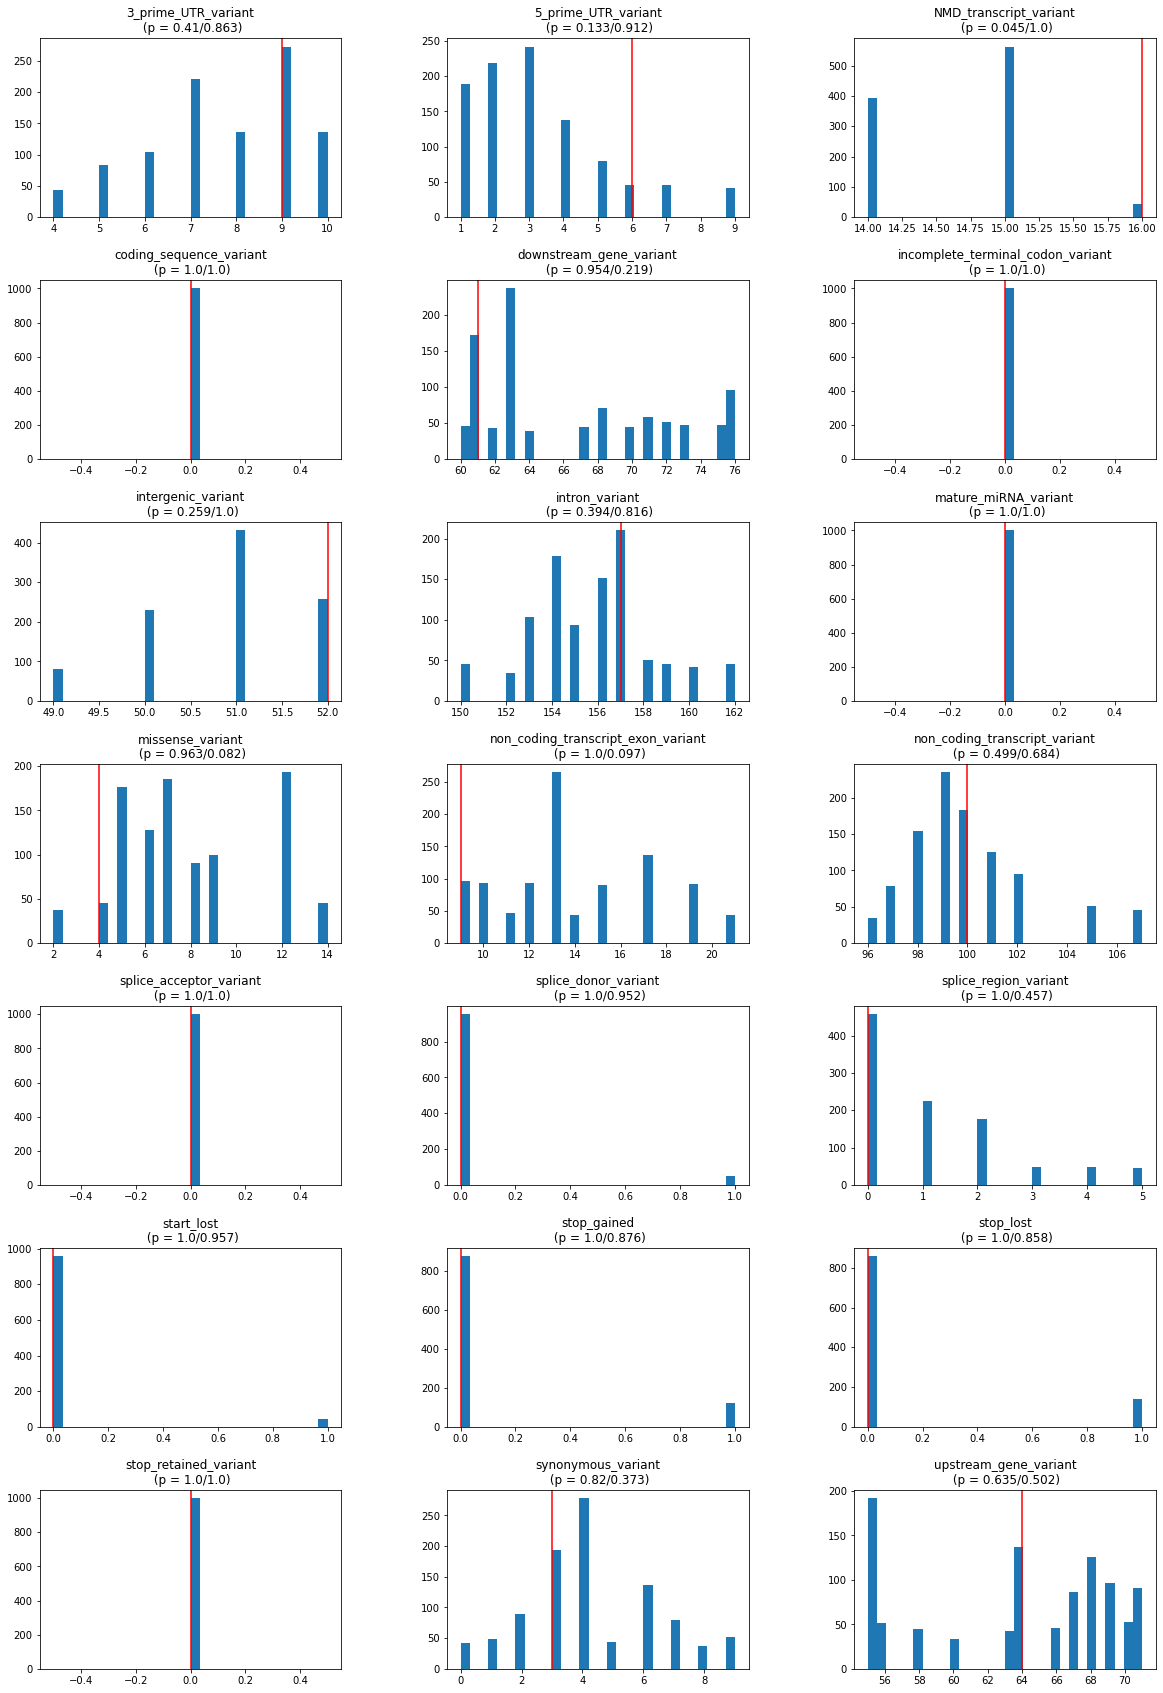

In [36]:
fig,axs = plt.subplots(nrows=7,ncols=3,figsize=(20,30),gridspec_kw={'wspace':0.35,'hspace':0.35})
i = 1 # chromosome
l = -1
for j in range(0,7):
    for k in range(0,3):
        l = l+1
        axs[j,k].hist(perm_results[i][l,::], bins=30)
        axs[j,k].set_title(str(annotations[l]) + "\n" + " (p = " + str(np.around(p_vals_e[i-1][l], decimals=3)) + "/" + str(np.around(p_vals_d[i-1][l], decimals=3)) + ")")
        axs[j,k].axvline(x=original_number[i][l], color='r', label= 'observed number' )

#fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center', fontsize = 20)
#fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical', fontsize=20)
#for ax in axs.flat:
   # ax.set(xlabel='Number of significant SNPs', ylabel='Frequency')

plt.savefig("chrom" +str(i)+ "numba")

In [43]:
# load in the data from the numpy loop
perms_two = {}

for i in range(1, 23):
    perms_two[i] = pd.read_csv(f"{i}_permutation_data_1000.tsv", sep="\t").to_numpy()


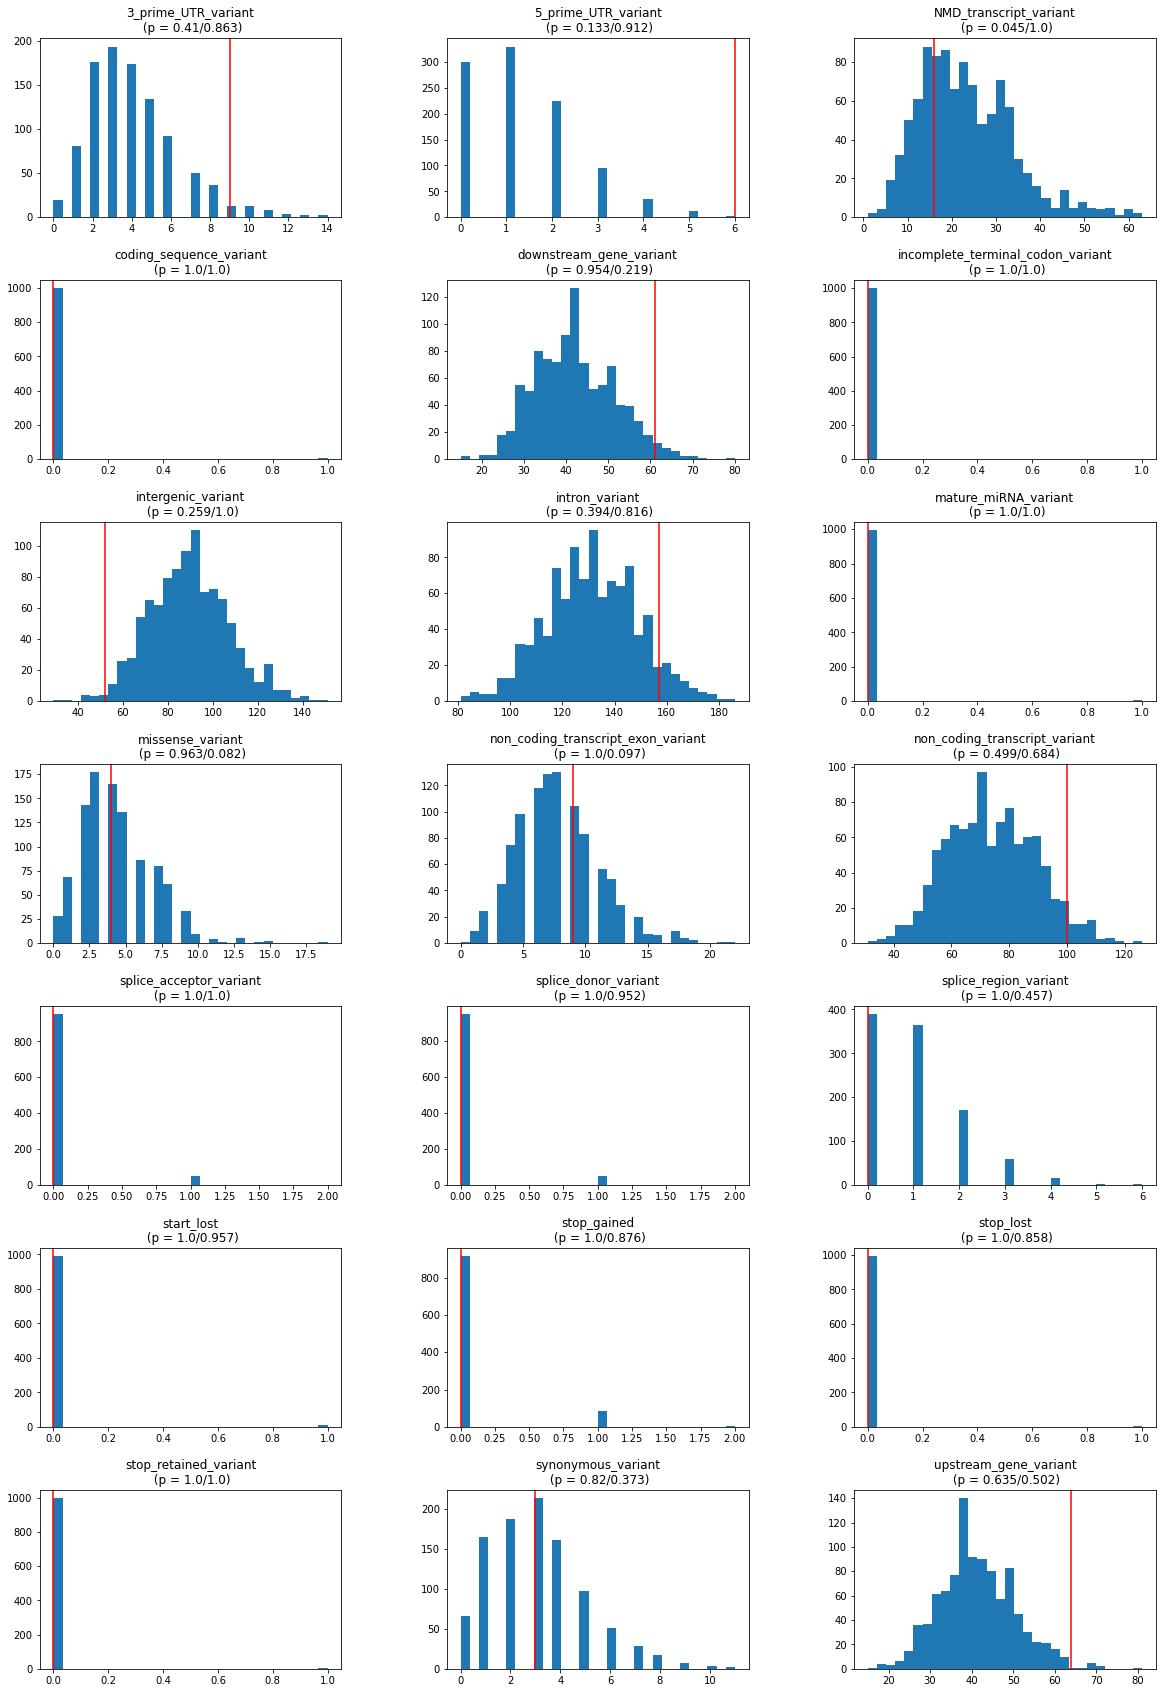

In [45]:
fig,axs = plt.subplots(nrows=7,ncols=3,figsize=(20,30),gridspec_kw={'wspace':0.35,'hspace':0.35})
i = 1 # chromosome
l = -1
for j in range(0,7):
    for k in range(0,3):
        l = l+1
        axs[j,k].hist(perms_two[i][l,::], bins=30)
        axs[j,k].set_title(str(annotations[l]) + "\n" + " (p = " + str(np.around(p_vals_e[i-1][l], decimals=3)) + "/" + str(np.around(p_vals_d[i-1][l], decimals=3)) + ")")
        axs[j,k].axvline(x=original_number[i][l], color='r', label= 'observed number' )

#fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center', fontsize = 20)
#fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical', fontsize=20)
#for ax in axs.flat:
   # ax.set(xlabel='Number of significant SNPs', ylabel='Frequency')

plt.savefig("chrom" +str(i)+ "numpy")

